You need to work on a popular Fashion MNIST dataset for this HW. The dataset includes tiny images of fashion pieces. The objective is to create a set of supervised learning models that can predict the type of item based on its image.

In order to load the dataset you need to have `tensorflow V2` on your computer. Use the following code to install the package

In [2]:
# !pip install --upgrade tensorflow

You can also check the version of it using the following code.

In [3]:
import tensorflow as tf
tf.__version__

/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


'2.19.0'

Now, it's time to load the dataset

In [4]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

As can be seen from the above code, the dataset was divided into train and test sets. Let's take a look at the X_train

In [5]:
X_train.shape

(60000, 28, 28)

As it is clear, the train dataset (`X_train`) contains 60,000 images of size 28 x 28. We can visualize one of the images using the following code:

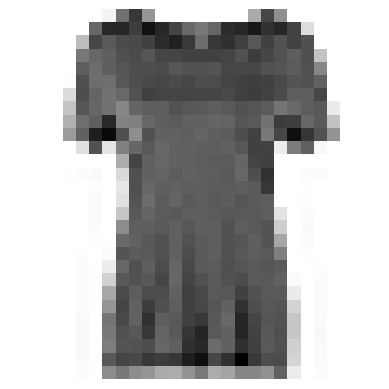

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sample_image = X_train[10]
plt.imshow(sample_image, cmap='binary')
plt.axis('off')
plt.show()

The `y_train` also includes values between 0 and 9. Each represents a particular category. For example, we can check the value of `y_train` for the above image.

In [7]:
y_train[10]

0

The above code shows that the image belongs to category 0. To get the associated label with each category, you can use the following code:

In [8]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(class_names[y_train[10]])

T-shirt/top


<ul>
    <li><b>Task1:</b> Use the train set to train various supervised models and evaluate their performance using the test set.</li>
    <ul>
        <li>Use different supervised learning models.</li>
        <li>Use different metrics such as <b>accuracy</b>, <b>precision</b>, <b>AUC</b>, and ... in your model evaluation. </li>
        <li>It is not enough to report the metrics. It is crucial that you interpret the metrics for each model and compare them across different models.</li>
        <li> You may need to use the cross validation methods for hyperparameter selection.</li>
        <li> Specify the model that outperforms the other models.</b>
    </ul>
    <li><b>Task2:</b> Use the best model to predict your own fashion pieces.</li>
    <ul>
        <li>Take a picture of ten fashion pieces of your own (take pictures in square format).</li>
        <li>Resize images to the correct size (28,28).</li>
        <li>Grayscale your images.</li>
        <li>Visualize all the images side by side</li>
        <li>Use the best model in Task 1 to predict the label of each of your own images.</li>
        <li>How accurate is the final result?</li>
    </ul>
</ul>

### Output

<ul>
    <li>Make sure to put descriptive comments on your code</li>
    <li>Use the markdown cell format in Jupiter to add your own interpretation to the result in each section.</li>
    <li>Make sure to keep the output of your runs when you want to save the final version of the file.</li>
    <li>The final work should be very well structured and should have a consistent flow of analysis.</li>
</ul>

# 0. Setup

In [9]:
# %pip -q install -U tensorflow scikit-learn matplotlib seaborn pillow

import sys, platform, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import os, glob

print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)

Python: 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
Platform: macOS-15.5-arm64-arm-64bit
TensorFlow: 2.19.0


# 1. Load Fashion-MNIST and Basic EDA

In [10]:
# Load Fashion-MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

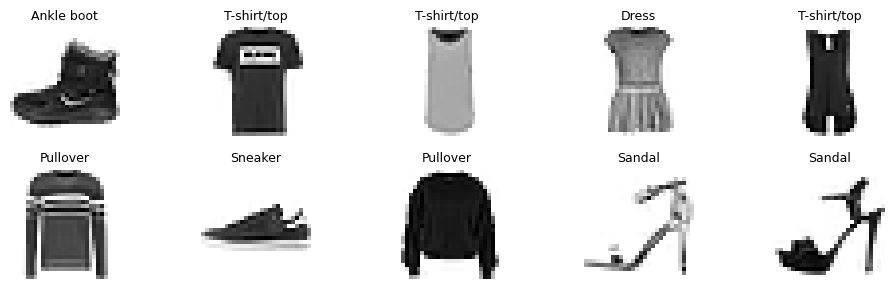

In [11]:
# Visualize a few samples
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Preprocessing
We’ll prepare two pipelines:

- For classical ML (LogReg/SVM/RF): flatten 28x28 to 784 features; scale if needed.

- For CNN: keep 28x28x1, normalize to.

In [12]:
# Normalization
X_train_cnn = (X_train.astype("float32") / 255.0)[..., np.newaxis]
X_test_cnn  = (X_test.astype("float32") / 255.0)[..., np.newaxis]

# Flatten for classical ML
X_train_flat = X_train.reshape(len(X_train), -1).astype("float32")/255.0
X_test_flat  = X_test.reshape(len(X_test), -1).astype("float32")/255.0

num_classes = 10

# 3. Baselines and Classical Models (Task 1)
We will evaluate:

- Logistic Regression (multinomial)
- Linear SVM and RBF SVM (using probabilities via probability=True)
- Random Forest

We’ll compute accuracy, macro-precision, and OvR ROC-AUC (requires predict_proba). For SVM linear we’ll do two runs: one with calibrated probs via probability=True (note the slower training) or use decision_function with OneVsRestClassifier+CalibratedClassifierCV if desired. To keep runtime sane, we’ll limit grid sizes.

In [13]:
def evaluate_model(clf, X_tr, y_tr, X_te, y_te, model_name):
    y_proba = None
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_te)
    elif hasattr(clf, "decision_function"):
        # Convert decision scores to probabilities via softmax-like normalization per class
        # Note: not a calibrated probability; acceptable for a rough AUC comparison if needed
        scores = clf.decision_function(X_te)
        # If binary shape, convert to two-column
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        # Min-max per row to 0..1
        s_min = scores.min(axis=1, keepdims=True)
        s_max = scores.max(axis=1, keepdims=True)
        denom = np.where((s_max - s_min)==0, 1, (s_max - s_min))
        y_proba = (scores - s_min) / denom

    y_pred = clf.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec_macro = precision_score(y_te, y_pred, average='macro', zero_division=0)

    auc_ovr = None
    if y_proba is not None:
        # One-vs-Rest multiclass AUC with macro averaging
        y_true_bin = keras.utils.to_categorical(y_te, num_classes=num_classes)
        try:
            auc_ovr = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
        except Exception:
            auc_ovr = None

    print(f"{model_name} — Accuracy: {acc:.4f} | Macro-Precision: {prec_macro:.4f} | OvR AUC: {auc_ovr if auc_ovr is not None else 'n/a'}")
    return {"model": model_name, "acc": acc, "prec_macro": prec_macro, "auc_ovr": auc_ovr}

results = []

## 3.1 Logistic Regression (with small grid search)

In [14]:
# Use a smaller subset for grid search to speed up tuning
from sklearn.model_selection import train_test_split
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=8000, stratify=y_train, random_state=42)
pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False safer for sparse-like; here dense but fine
    ("clf", LogisticRegression(max_iter=200, solver='saga', tol=1e-3, n_jobs=-1))
])

param_lr = {
    "clf__C": [1.0, 0.5, 2.0]
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_lr.fit(X_train_sub, y_train_sub)
best_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=200, solver='saga', tol=1e-3, n_jobs=-1, C=grid_lr.best_params_["clf__C"]))
])
print("training full dataset")
best_lr.fit(X_train_flat, y_train)
print("LR best params:", grid_lr.best_params_)

res_lr = evaluate_model(best_lr, X_train_flat, y_train, X_test_flat, y_test, "LogisticRegression")
results.append(res_lr)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........................................clf__C=1.0; total time=  40.3s
[CV] END .........................................clf__C=2.0; total time=  40.2s
[CV] END .........................................clf__C=1.0; total time=  40.4s
[CV] END .........................................clf__C=0.5; total time=  40.4s


/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........................................clf__C=0.5; total time=  40.5s
[CV] END .........................................clf__C=2.0; total time=  40.5s


/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR best params: {'clf__C': 1.0}
LogisticRegression — Accuracy: 0.8459 | Macro-Precision: 0.8450 | OvR AUC: 0.9834649888888889


/Users/chhaviverma/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 3.2 Support Vector Machines
Linear SVM (probability=True uses Platt scaling internally; slower):

In [ ]:
# Use a smaller subset for grid search to speed up tuning (same as logreg)
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=8000, stratify=y_train, random_state=42)
pipe_svm_lin = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", SVC(kernel='linear', probability=True))
])

param_svm_lin = {"clf__C": [0.5, 1.0]}
grid_svm_lin = GridSearchCV(pipe_svm_lin, param_svm_lin, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_svm_lin.fit(X_train_sub, y_train_sub)
best_svm_lin = grid_svm_lin.best_estimator_
print("SVM-linear best params:", grid_svm_lin.best_params_)

# Retrain best SVM-linear on full data for evaluation
best_svm_lin.fit(X_train_flat, y_train)
res_svm_lin = evaluate_model(best_svm_lin, X_train_flat, y_train, X_test_flat, y_test, "SVM-Linear")
results.append(res_svm_lin)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .........................................clf__C=0.5; total time=  24.6s
[CV] END .........................................clf__C=1.0; total time=  24.8s
[CV] END .........................................clf__C=0.5; total time=  24.6s
[CV] END .........................................clf__C=1.0; total time=  24.8s
[CV] END .........................................clf__C=1.0; total time=  25.6s
[CV] END .........................................clf__C=0.5; total time=  25.7s
[CV] END .........................................clf__C=1.0; total time=  25.6s
[CV] END .........................................clf__C=0.5; total time=  25.7s
SVM-linear best params: {'clf__C': 0.5}
SVM-linear best params: {'clf__C': 0.5}


### RBF SVM:



In [ ]:
# Use a smaller subset for grid search to speed up tuning (same as logreg)
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=8000, stratify=y_train, random_state=42)
pipe_svm_rbf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", SVC(kernel='rbf', probability=True))
])

param_svm_rbf = {"clf__C": [1.0], "clf__gamma": ['scale']}
grid_svm_rbf = GridSearchCV(pipe_svm_rbf, param_svm_rbf, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_svm_rbf.fit(X_train_sub, y_train_sub)
best_svm_rbf = grid_svm_rbf.best_estimator_
print("SVM-RBF best params:", grid_svm_rbf.best_params_)

# Retrain best SVM-RBF on full data for evaluation
best_svm_rbf.fit(X_train_flat, y_train)
res_svm_rbf = evaluate_model(best_svm_rbf, X_train_flat, y_train, X_test_flat, y_test, "SVM-RBF")
results.append(res_svm_rbf)


## 3.3 Random Forest

In [ ]:
# Use a smaller subset for initial fitting to speed up tuning (same as logreg)
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=8000, stratify=y_train, random_state=42)
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42, class_weight=None
)
rf.fit(X_train_sub, y_train_sub)
# Retrain on full data for evaluation
rf.fit(X_train_flat, y_train)
res_rf = evaluate_model(rf, X_train_flat, y_train, X_test_flat, y_test, "RandomForest")
results.append(res_rf)


## 3.4 Compare Classical Models

In [ ]:
import pandas as pd
df_results = pd.DataFrame(results).sort_values(by="acc", ascending=False)
df_results


# add confusion matrices:

In [ ]:
best_name = df_results.iloc[0]["model"]
best_clf = {
    "LogisticRegression": best_lr,
    "SVM-Linear": best_svm_lin,
    "SVM-RBF": best_svm_rbf,
    "RandomForest": rf
}[best_name]

y_pred_best = best_clf.predict(X_test_flat)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred_best, target_names=class_names))


# 4. CNN Model (Task 1, Deep Learning)
A compact CNN often outperforms classical models on Fashion-MNIST.

In [ ]:
def make_cnn():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = make_cnn()
history = cnn.fit(
    X_train_cnn, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=128,
    verbose=1
)

test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test, verbose=2)
print(f"CNN — Accuracy: {test_acc:.4f}")

y_proba_cnn = cnn.predict(X_test_cnn, verbose=2)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

prec_macro_cnn = precision_score(y_test, y_pred_cnn, average='macro', zero_division=0)
y_true_bin = keras.utils.to_categorical(y_test, num_classes=num_classes)
auc_ovr_cnn = roc_auc_score(y_true_bin, y_proba_cnn, average='macro', multi_class='ovr')

print(f"CNN — Macro-Precision: {prec_macro_cnn:.4f} | OvR AUC: {auc_ovr_cnn:.4f}")


Add a markdown interpretation comparing CNN vs the best classical model:

Accuracy and macro-precision differences

CNN’s ability to capture spatial structure vs flattened features

Optional: confusion matrix for CNN.

In [ ]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(7,6))
sns.heatmap(cm_cnn, annot=False, cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — CNN")
plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred_cnn, target_names=class_names))


# 5. Pick Best Model

In [ ]:
# Consolidate with CNN metrics
row_cnn = {"model":"CNN", "acc": float(test_acc), "prec_macro": float(prec_macro_cnn), "auc_ovr": float(auc_ovr_cnn)}
df_all = pd.concat([df_results, pd.DataFrame([row_cnn])]).sort_values(by="acc", ascending=False)
df_all


Add markdown:

State the best model (likely CNN by accuracy and AUC).

Briefly justify selection and note any trade-offs (training time vs performance).

If the classical model somehow wins (rare), proceed with that instead for Task 2.

# 6. Task 2: Predict On Your Own 10 Images
Instructions:

Take 10 square photos (one per class if possible).

Save as PNG/JPG in a folder.

The pipeline: load → convert to grayscale → resize to 28x28 → normalize → shape to (28,28,1) → batch predict.

In [ ]:
# Path with 10 images
user_img_dir = "YOUR_10_IMAGES_FOLDER"  # e.g., "my_fashion_photos"
paths = sorted(glob.glob(os.path.join(user_img_dir, "*.*")))
assert len(paths) >= 10, f"Found {len(paths)} images, need at least 10."

def load_and_prepare_image(p, target=(28,28)):
    img = Image.open(p).convert("L")   # grayscale
    img = img.resize(target)           # ensure (28,28)
    arr = np.array(img, dtype="float32")/255.0
    return arr

user_imgs = [load_and_prepare_image(p) for p in paths[:10]]
user_stack_cnn = np.stack(user_imgs)[..., np.newaxis]  # (N,28,28,1)


Visualize side-by-side:



In [ ]:
plt.figure(figsize=(10,3))
for i, (p, arr) in enumerate(zip(paths[:10], user_imgs)):
    plt.subplot(2,5,i+1)
    plt.imshow(arr, cmap='binary')
    plt.title(os.path.basename(p)[:12], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


Predict with the best model (choose CNN if it won):



In [ ]:
use_cnn = df_all.iloc[0]["model"] == "CNN"

if use_cnn:
    probs = cnn.predict(user_stack_cnn, verbose=2)
    preds = np.argmax(probs, axis=1)
else:
    # If a classical model won:
    user_stack_flat = user_stack_cnn.reshape(len(user_imgs), -1)
    best_name = df_all.iloc[0]["model"]
    best_clf = {
        "LogisticRegression": best_lr,
        "SVM-Linear": best_svm_lin,
        "SVM-RBF": best_svm_rbf,
        "RandomForest": rf
    }[best_name]
    preds = best_clf.predict(user_stack_flat)

pred_labels = [class_names[i] for i in preds]
pred_labels


If you have ground-truth labels for your images (optional), compute accuracy:



In [ ]:
# Optional: set your true labels if known (list of 10 strings matching class_names)
# Example: y_true_names = ['Sneaker','Bag',...]
y_true_names = None  # replace with actual list

if y_true_names is not None:
    true_idx = [class_names.index(n) for n in y_true_names]
    pred_acc = accuracy_score(true_idx, preds)
    print("User images accuracy:", pred_acc)


# 7. Short Discussion and Conclusions
Use markdown to:

Summarize which model outperformed and by how much.

Interpret metric differences (accuracy vs macro-precision vs AUC).

Mention practical considerations (speed, simplicity, deployment).

Note improvements: data augmentation, deeper CNN (BatchNorm, more epochs), regularization, or transfer learning variants.

